In [2]:
%matplotlib inline
%pylab inline
from utils import *

# Settings
input_dim = 99 #89-2 #27*2
output_dim = 1
nseqlen = 128
fdir = "/media/lukasz/TOSHIBA EXT/csv-hee"

# Load data
inputs, outputs, ids = load_data(fdir, input_dim, output_dim, nseqlen, nsamples = 10000)

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [8]:
n = inputs.shape[0]
ntrain = int(math.floor(n * 0.9))
print(ntrain)

peaks = [[0,1], [2,2], [2,0]]
index, value = max(enumerate(peaks), key=lambda x: x[1][1])
print(index)

9000
1


In [4]:
from keras.models import load_model
import keras
from numpy import mean
from utils import weighted_binary_crossentropy
keras.objectives.weighted_binary_crossentropy = weighted_binary_crossentropy
model = load_model("model-48-4.h5")

[[   0.         -174.19055176]
 [  55.         -313.72357178]
 [ 100.           59.65460205]]


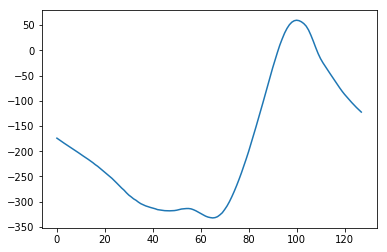

In [83]:
subj = 269
plt.plot(inputs[subj][:,42])

print(peakdet(inputs[subj][:,42],0.5)[0])
#plt.plot(outputs[subj][:,0])


Error distribution:
<= 1: 0.831847
<= 3: 0.967551
<= 5: 0.988069
<= 10: 0.997547
<= 60: 0.999888
Mean distance: 0.946142


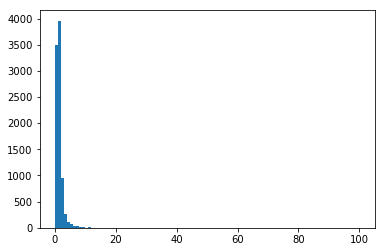

In [30]:
#cols = range(15) + [30 + i for i in range(6)] + [54 + i for i in range(6)] + [12 + 81 + i for i in range(6)] 
cols = range(15) + [60 + i for i in range(12)] + [12 + 81 + i for i in range(6)]
res = model.predict(inputs[0:ntrain,:,cols])
sdist = []

for ntrial in range(ntrain):
    likelihood = res[ntrial,:,:]
    true = outputs[ntrial,:,:]
    d = eval_prediction(likelihood, true, ids[ntrial], plot = False, shift = 0)
    sdist.extend(d)
plot_stats(sdist)

Error distribution:
<= 1: 0.459212
<= 3: 0.836848
<= 5: 0.945536
<= 10: 0.989758
<= 60: 1.000000
Mean distance: 2.136040
0.0696666666667
Error distribution:
<= 1: 0.444862
<= 3: 0.844765
<= 5: 0.954193
<= 10: 0.991154
<= 60: 1.000000
Mean distance: 2.103369
0.0828888888889


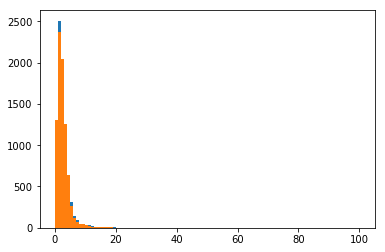

In [39]:
# 30
# 46
def coordinate_pred(inputs, nseqlen):
    outputs = np.zeros((inputs.shape[0], inputs.shape[1], 1))

    for i in range(inputs.shape[0]):
        try:
            peaks = peakdet(inputs[i][:,42],0.5)[0]
            #print(peaks)
            index, value = max(enumerate(peaks), key=lambda x: x[1][1])
            
            outputs[i,int(peaks[index][0]),0] = 1
        except:
            pass
        
    return outputs

def velocity_pred(inputs, nseqlen):
    outputs = np.zeros((inputs.shape[0], inputs.shape[1], 1))

    for i in range(inputs.shape[0]):
        try:
            v = inputs[i][:,63]
            v = np.sign(v)
            k = np.where(-2 == v[1:] - v[:-1])
            k = k[0]
            for j in k:
                outputs[i,j,0] = 1
            # k = peakdet(v,0.5)[0][1][0]
        except:
            pass
        
    return outputs

def plot_stats(sdist):
    plt.hist(sdist,100,[0, 100])
    filtered = [k for k in sdist if k >= 0]
    
    def off_by(threshold, filtered):
        ob = [k for k in filtered if k <= threshold]
        nel = float(len(filtered))
        print("<= %d: %f" % (threshold, len(ob) / float(nel)))
        
    
    print("Error distribution:")
    off_by(1, filtered)
    off_by(3, filtered)
    off_by(5, filtered)
    off_by(10, filtered)
    off_by(60, filtered)
    print("Mean distance: %f" % (np.mean(filtered)))
 

res = velocity_pred(inputs, 128)
sdist = []
for ntrial in range(ntrain):
    likelihood = res[ntrial,:,:]
    true = outputs[ntrial,:,:]
    d = eval_prediction(likelihood, true, ids[ntrial], plot = False, shift = 4)
    sdist.extend(d)
plot_stats([k for k in sdist if k > -0.5 and k < 20])
#plot_stats(sdist)
#print(sdist)
print(len([k for k in sdist if k > 20]) / float(len(sdist)))

res = coordinate_pred(inputs, 128)
sdist = []
for ntrial in range(ntrain):
    likelihood = res[ntrial,:,:]
    true = outputs[ntrial,:,:]
    d = eval_prediction(likelihood, true, ids[ntrial], plot = False, shift = 4)
    sdist.extend(d)
plot_stats([k for k in sdist if k > -0.5 and k < 20])
print(len([k for k in sdist if k > 20]) / float(len(sdist)))
#plot_stats(sdist)
#print(sdist)
